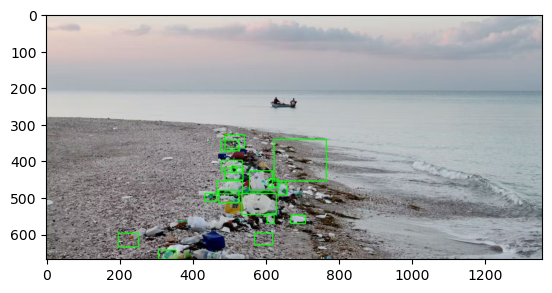

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
# Load the image
image = cv2.imread("D:\cvdataset\image-20150212-16595-1yv1xnx.jpg")

# Convert the image to the RGB color space
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

pixels = image_rgb.reshape((-1, 3))

# K-Means clustering
k = 2 
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2)
_, labels, centers = cv2.kmeans(pixels.astype(np.float32), k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)

# Convert the labels back to the shape of the original image
segmented_image_kmeans = labels.reshape(image.shape[:2])

# Create binary masks for each segment
masks = []
for i in range(k):
    mask = np.uint8(segmented_image_kmeans == i)
    masks.append(mask)

# Apply morphological operations to refine masks
kernel = np.ones((5, 5), np.uint8)
refined_masks = []
for mask in masks:
    erosion = cv2.erode(mask, kernel, iterations=1)
    dilation = cv2.dilate(erosion, kernel, iterations=1)
    refined_masks.append(dilation)

# Detect objects using contour detection
contours_list = []
for mask in refined_masks:
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours_list.extend(contours)

# Filter and classify objects based on size, shape, and color
filtered_objects = []
for contour in contours_list:
    area = cv2.contourArea(contour)
    perimeter = cv2.arcLength(contour, True)
    approx = cv2.approxPolyDP(contour, 0.02 * perimeter, True)
    
    # Customize these criteria for your specific waste detection
    if area > 100 and len(approx) >= 10:
        x, y, w, h = cv2.boundingRect(contour)
        roi = image[y:y+h, x:x+w]
        
        # Example: Check for specific color (green) within the bounding box
        hsv_roi = cv2.cvtColor(roi, cv2.COLOR_RGB2HSV)
        lower_green = np.array([20, 40, 20])
        upper_green = np.array([80, 255, 255])
        green_mask = cv2.inRange(hsv_roi, lower_green, upper_green)
        
        if cv2.countNonZero(green_mask) > 0:
            filtered_objects.append((x, y, w, h))

# Draw rectangles around filtered objects
result_image = image.copy()
for (x, y, w, h) in filtered_objects:
    cv2.rectangle(result_image, (x, y), (x + w, y + h), (0, 255, 0), 2)
   
result_image = cv2.cvtColor(result_image,cv2.COLOR_BGR2RGB)
plt.imshow(result_image)
plt.show()



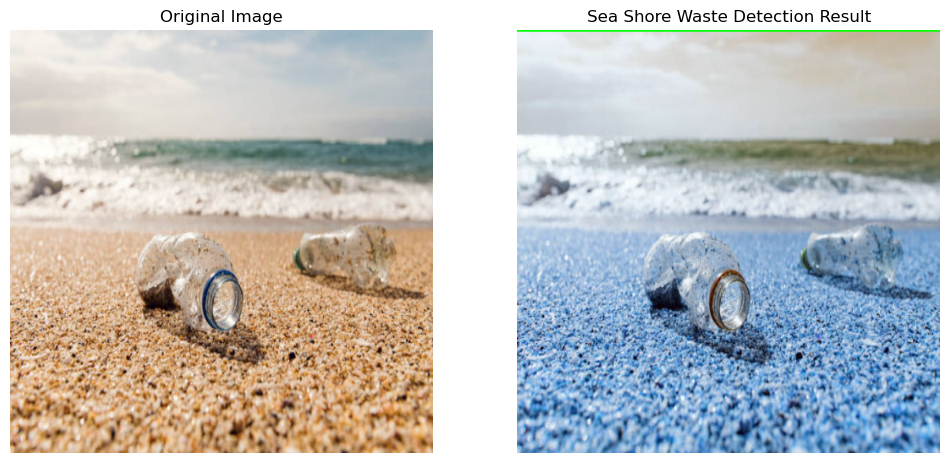

In [6]:
import cv2
import numpy as np
from skimage.feature import graycomatrix, graycoprops
from skimage.filters import gabor
from skimage import io, color, img_as_ubyte
import matplotlib.pyplot as plt

def apply_bilateral_filter(image):
    filtered_image = cv2.bilateralFilter(image, d=9, sigmaColor=75, sigmaSpace=75 )
    return filtered_image

image = cv2.imread(r"D:\cv_images\trash4.jpg")
resized_image = cv2.resize(image, (500, 500))
gray_image = cv2.cvtColor(resized_image, cv2.COLOR_BGR2GRAY)

filtered_gray_image = apply_bilateral_filter(gray_image)
glcm = graycomatrix(filtered_gray_image, [1], [0], symmetric=True, normed=True)
homogeneity = graycoprops(glcm, 'homogeneity')[0, 0]
threshold = 0.5
corrosion_mask_homogeneity = (homogeneity < threshold).astype(np.uint8) * 255

def compute_gabor_features(image):
    gabor_responses = np.abs(gabor(image, frequency=100, theta=0))
    gabor_responses = (gabor_responses - np.min(gabor_responses)) / (np.max(gabor_responses) - np.min(gabor_responses))
    return gabor_responses

gabor_features = compute_gabor_features(filtered_gray_image)

gabor_threshold = 0.3
corrosion_mask_gabor = (gabor_features < gabor_threshold).astype(np.uint8) * 255
corrosion_mask_homogeneity = np.array(corrosion_mask_homogeneity)
corrosion_mask_gabor = np.array(corrosion_mask_gabor)

# Bitwise AND operation
final_mask = cv2.bitwise_and(corrosion_mask_homogeneity, corrosion_mask_gabor)
final_mask = np.asarray(final_mask)
result_image = cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB)
white_pixel_coords = np.argwhere(final_mask == 255)
for coord in white_pixel_coords:
    y, x, _ = coord 
    result_image[y, x] = [0, 255, 0]


# Original Image
# Convert BGR to RGB for correct display in Matplotlib
resized_image_rgb = cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB)
result_image_rgb = cv2.cvtColor(result_image, cv2.COLOR_BGR2RGB)

# Display the result using Matplotlib
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Original Image
axes[0].imshow(resized_image_rgb)
axes[0].set_title('Original Image')
axes[0].axis('off')

# Rust Detected Image
axes[1].imshow(result_image_rgb)
axes[1].set_title('Sea Shore Waste Detection Result')
axes[1].axis('off')

plt.show()



In [2]:
import cv2
import numpy as np
from skimage.io import imread, imshow
from skimage.color import rgb2hsv
import matplotlib.pyplot as plt

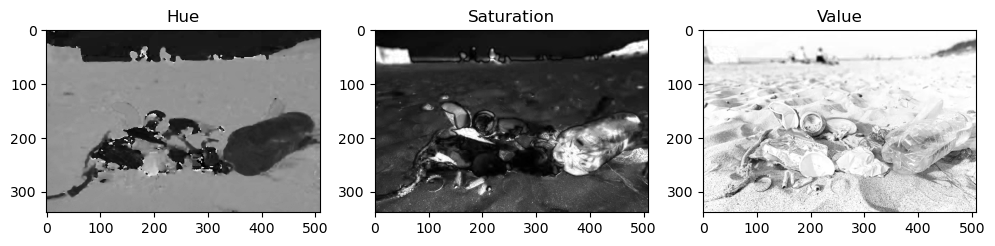

In [17]:
bags = cv2.imread(r"D:\cv_images\trash2.jpg")
bags_hsv = rgb2hsv(bags)
fig, ax = plt.subplots(1, 3, figsize=(12,4))
ax[0].imshow(bags_hsv[:,:,0], cmap='gray')
ax[0].set_title('Hue')
ax[1].imshow(bags_hsv[:,:,1], cmap='gray')
ax[1].set_title('Saturation')
ax[2].imshow(bags_hsv[:,:,2], cmap='gray')
ax[2].set_title('Value');

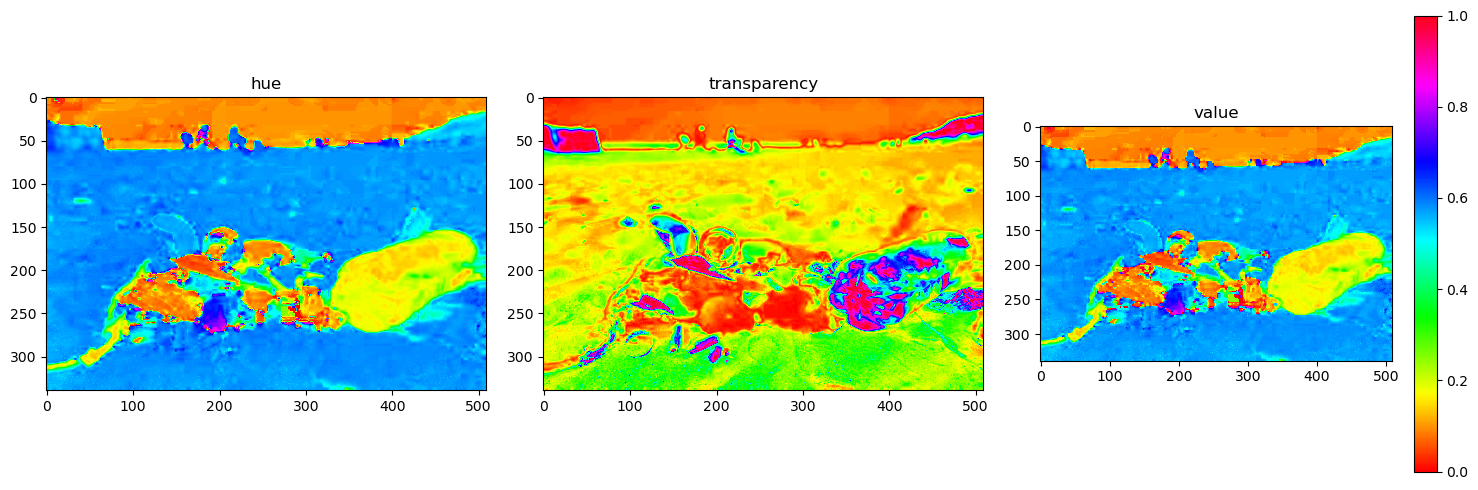

In [18]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(bags_hsv[:,:,0],cmap='hsv')
ax[0].set_title('hue')
ax[1].imshow(bags_hsv[:,:,1],cmap='hsv')
ax[1].set_title('transparency')
ax[2].imshow(bags_hsv[:,:,2],cmap='hsv')
ax[2].set_title('value')
fig.colorbar(imshow(bags_hsv[:,:,0],cmap='hsv')) 
fig.tight_layout()

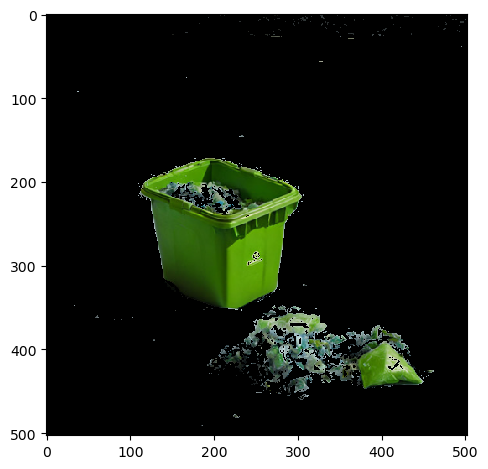

In [14]:
#refer to hue channel (in the colorbar)
lower_mask = bags_hsv[:,:,0] > 0.2 
#refer to hue channel (in the colorbar)
upper_mask = bags_hsv[:,:,0] < 0.55
#refer to transparency channel (in the colorbar)
saturation_mask = bags_hsv[:,:,1] > 0.1
 
mask = upper_mask*lower_mask*saturation_mask
red = bags[:,:,0]*mask
green = bags[:,:,1]*mask
blue = bags[:,:,2]*mask
bags_masked = np.dstack((red,green,blue))
imshow(bags_masked)

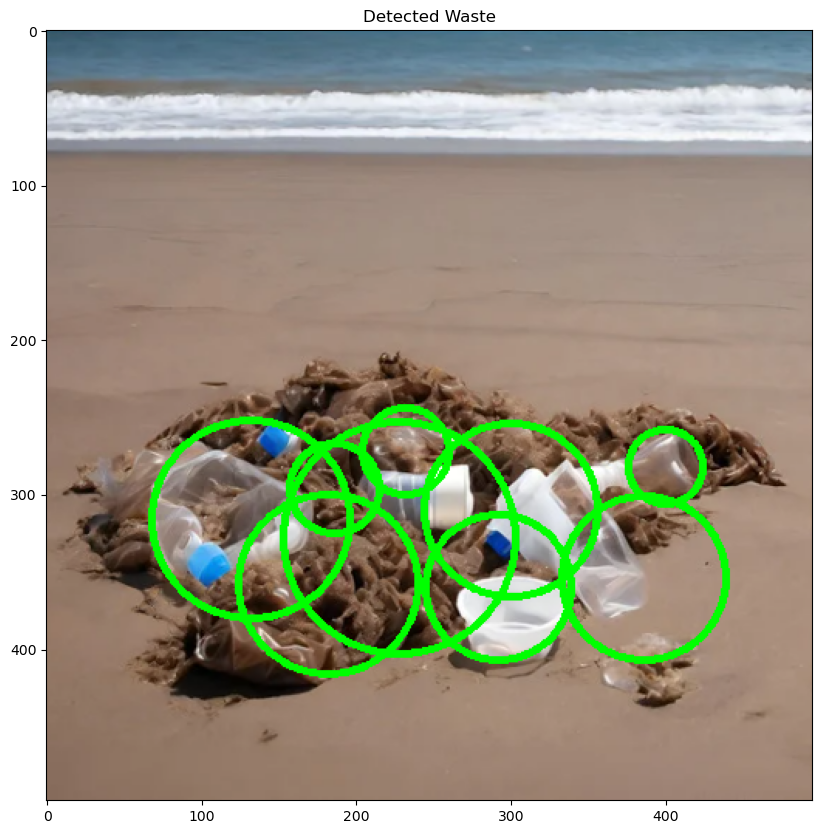

In [6]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load image
image = cv2.imread("D:\cv_images\Screenshot 2023-10-15 142016.png")

# Convert to grayscale
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Apply bilateral filter
bilateral = cv2.bilateralFilter(gray, 9, 75, 75)

# Apply morphological operations
kernel = np.ones((3,3), np.uint8)
dilated = cv2.dilate(bilateral, kernel, iterations=1)
eroded = cv2.erode(dilated, kernel, iterations=1)

# Detect edges using Canny
edges = cv2.Canny(eroded, 90, 190)

# Detect circles using HoughCircles
circles = cv2.HoughCircles(edges, cv2.HOUGH_GRADIENT, 0.5, 50, param1=25, param2=30, minRadius=0, maxRadius=0)

# Draw circles on the original image
if circles is not None:
    circles = np.round(circles[0, :]).astype("int")
    for (x, y, r) in circles:
        cv2.circle(image, (x, y), r, (0, 255, 0), 4)

# Display the original image with circles

plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title('Detected Waste')
plt.show()  

In [3]:
import cv2
import numpy as np
from skimage import feature

# Read the input image
image = cv2.imread("D:\cv_images\Screenshot 2023-10-15 142016.png")

# Convert the image to grayscale
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Apply bilateral filtering to reduce noise while preserving edges
filtered_image = cv2.bilateralFilter(gray, 9, 75, 75)

# Apply morphological operations to enhance features
kernel = np.ones((5, 5), np.uint8)
morph_image = cv2.morphologyEx(filtered_image, cv2.MORPH_CLOSE, kernel)

# Apply Gabor filter for texture features
gabor_kernel = cv2.getGaborKernel((21, 21), 5.0, np.pi / 4, 10.0, 0.5, 0, ktype=cv2.CV_32F)
gabor_image = cv2.filter2D(morph_image, cv2.CV_8UC3, gabor_kernel)

# Apply Local Binary Pattern (LBP) for texture features
lbp_image = feature.local_binary_pattern(morph_image, P=8, R=1, method="uniform")

# Threshold the image to obtain binary mask
_, binary_mask = cv2.threshold(gabor_image, 50, 150, cv2.THRESH_BINARY)

# Display the results
cv2.imshow('Original Image', image)
cv2.imshow('Filtered Image', filtered_image)
cv2.imshow('Morphological Image', morph_image)
cv2.imshow('Gabor Image', gabor_image)
cv2.imshow('LBP Image', lbp_image)
cv2.imshow('Binary Mask', binary_mask)

cv2.waitKey(0)
cv2.destroyAllWindows()
